Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

Data Loading and Preprocessing

In [ ]:
DATA_PATH = 'data.csv'
np.random.seed(42)

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Loaded raw data: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"File '{DATA_PATH}' not found.")

df = df.dropna(axis=1, how='all')

df = df.dropna(axis=0)

if 'id' in df.columns:
    df = df.drop(columns=['id'])

target_col = None
possible_targets = ['diagnosis', 'target', 'label', 'class']
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col:
    y_raw = df[target_col].values
    if y_raw.dtype == object:
        unique_classes = np.unique(y_raw)
        class_map = {label: idx for idx, label in enumerate(unique_classes)}
        y = np.array([class_map[val] for val in y_raw])
    else:
        y = y_raw
    X_raw_df = df.drop(columns=[target_col])
else:
    y = None
    X_raw_df = df

X_raw_df = X_raw_df.apply(pd.to_numeric, errors='coerce')
X_raw_df = X_raw_df.dropna() 
X_raw = X_raw_df.values
X_mean = np.nanmean(X_raw, axis=0)
X_std = np.nanstd(X_raw, axis=0)

X_std[X_std == 0] = 1.0 

X_scaled = (X_raw - X_mean) / X_std

if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    raise ValueError("Preprocessing failed: X_scaled still contains NaNs or Infs. Check your dataset for non-numeric strings.")

print(f"Cleaned Data Shape: {X_scaled.shape}")

Loaded raw data: (569, 33)
Cleaned Data Shape: (569, 30)


GMM Implementation

In [7]:
class GaussianMixtureModel:
    def __init__(self, n_components=3, covariance_type='full', tol=1e-4, max_iter=100, reg_covar=1e-6):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.tol = tol
        self.max_iter = max_iter
        self.reg_covar = reg_covar
        
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.log_likelihood_history_ = []
        self.converged_ = False

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[indices]
        self.weights_ = np.full(self.n_components, 1 / self.n_components)
        
        if self.covariance_type == 'full':
            self.covariances_ = np.array([np.eye(n_features) for _ in range(self.n_components)])
        elif self.covariance_type == 'tied':
            self.covariances_ = np.eye(n_features)
        elif self.covariance_type == 'diag':
            self.covariances_ = np.ones((self.n_components, n_features))
        elif self.covariance_type == 'spherical':
            self.covariances_ = np.ones(self.n_components)

    def _e_step(self, X):
        n_samples, n_features = X.shape
        weighted_log_probs = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            if self.covariance_type == 'full':
                cov = self.covariances_[k] + np.eye(n_features) * self.reg_covar
            elif self.covariance_type == 'tied':
                cov = self.covariances_ + np.eye(n_features) * self.reg_covar
            elif self.covariance_type == 'diag':
                cov = np.diag(self.covariances_[k] + self.reg_covar)
            elif self.covariance_type == 'spherical':
                cov = np.eye(n_features) * (self.covariances_[k] + self.reg_covar)
            
            try:
                weighted_log_probs[:, k] = np.log(self.weights_[k] + 1e-10) + \
                                           multivariate_normal.logpdf(X, mean=self.means_[k], cov=cov)
            except np.linalg.LinAlgError:
                weighted_log_probs[:, k] = -np.inf

        log_prob_norm = self._log_sum_exp(weighted_log_probs)
        log_likelihood = np.sum(log_prob_norm)
        
        with np.errstate(under='ignore'):
            responsibilities = np.exp(weighted_log_probs - log_prob_norm[:, np.newaxis])
            
        return log_likelihood, responsibilities

    def _m_step(self, X, responsibilities):
        n_samples, n_features = X.shape
        Nk = responsibilities.sum(axis=0) + 1e-10
        
        self.weights_ = Nk / n_samples
        self.means_ = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        
        if self.covariance_type == 'full':
            for k in range(self.n_components):
                diff = X - self.means_[k]
                self.covariances_[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
        elif self.covariance_type == 'tied':
            avg_cov = np.zeros((n_features, n_features))
            for k in range(self.n_components):
                diff = X - self.means_[k]
                avg_cov += np.dot(responsibilities[:, k] * diff.T, diff)
            self.covariances_ = avg_cov / n_samples
        elif self.covariance_type == 'diag':
            for k in range(self.n_components):
                diff = X - self.means_[k]
                self.covariances_[k] = np.sum(responsibilities[:, k][:, np.newaxis] * (diff ** 2), axis=0) / Nk[k]
        elif self.covariance_type == 'spherical':
            for k in range(self.n_components):
                diff = X - self.means_[k]
                diff_sq_norm = np.sum(diff**2, axis=1)
                self.covariances_[k] = np.sum(responsibilities[:, k] * diff_sq_norm) / (Nk[k] * n_features)

    def fit(self, X):
        self._initialize_parameters(X)
        self.log_likelihood_history_ = []
        
        for i in range(self.max_iter):
            prev_ll = self.log_likelihood_history_[-1] if self.log_likelihood_history_ else -np.inf
            
            ll, resp = self._e_step(X)
            
            if np.isnan(ll):
                print(f"Warning: Training diverged at iteration {i}. Stopping.")
                break
                
            self.log_likelihood_history_.append(ll)
            
            if np.abs(ll - prev_ll) < self.tol:
                self.converged_ = True
                break
            
            self._m_step(X, resp)
        return self

    def _log_sum_exp(self, log_probs):
        max_log = np.max(log_probs, axis=1, keepdims=True)
        max_log[np.isinf(max_log)] = 0 
        return np.squeeze(max_log) + np.log(np.sum(np.exp(log_probs - max_log), axis=1))

    def bic(self, X):
        if not self.log_likelihood_history_: return np.inf
        n, d = X.shape
        return self._n_parameters(d) * np.log(n) - 2 * self.log_likelihood_history_[-1]

    def aic(self, X):
        if not self.log_likelihood_history_: return np.inf
        d = X.shape[1]
        return 2 * self._n_parameters(d) - 2 * self.log_likelihood_history_[-1]
    
    def _n_parameters(self, n_features):
        if self.covariance_type == 'full':
            cov_p = self.n_components * n_features * (n_features + 1) / 2
        elif self.covariance_type == 'diag':
            cov_p = self.n_components * n_features
        elif self.covariance_type == 'tied':
            cov_p = n_features * (n_features + 1) / 2
        elif self.covariance_type == 'spherical':
            cov_p = self.n_components
        return int(cov_p + self.n_components * n_features + (self.n_components - 1))

GMM on origonal Data

In [8]:
n_components_range = range(1, 8) 
covariance_types = ['full', 'tied', 'diag', 'spherical']
results_data = []
trained_models = {}

print("Starting Experiment 2...")

for cov_type in covariance_types:
    print(f"  Testing Covariance: {cov_type}")
    for n_comp in n_components_range:
        gmm = GaussianMixtureModel(n_components=n_comp, covariance_type=cov_type, max_iter=100)
        gmm.fit(X_scaled)
        
        bic_score = gmm.bic(X_scaled)
        aic_score = gmm.aic(X_scaled)
        final_ll = gmm.log_likelihood_history_[-1]
        
        results_data.append({
            'covariance_type': cov_type,
            'n_components': n_comp,
            'BIC': bic_score,
            'AIC': aic_score,
            'Log_Likelihood': final_ll
        })
        
        trained_models[(cov_type, n_comp)] = gmm

results_df = pd.DataFrame(results_data)
print("Experiment 2 Completed.")

Starting Experiment 2...
  Testing Covariance: full
  Testing Covariance: tied
  Testing Covariance: diag
  Testing Covariance: spherical
Experiment 2 Completed.


Visualization

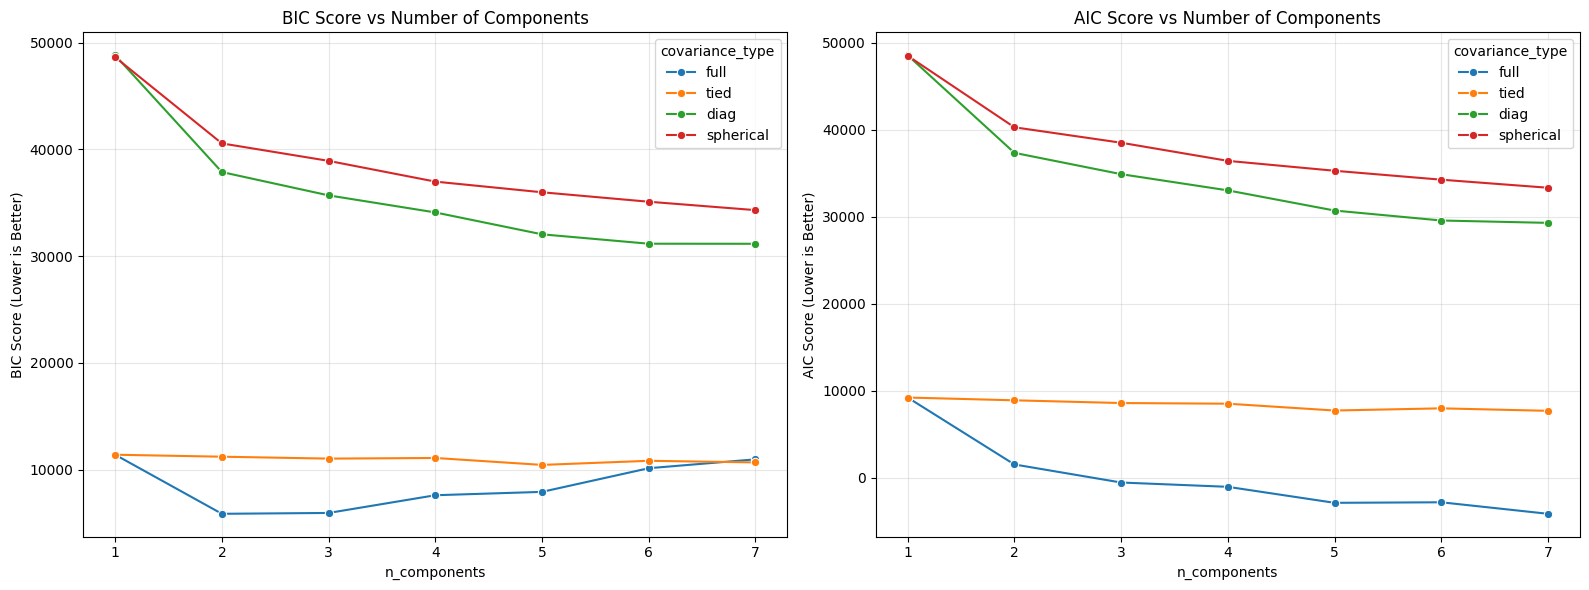

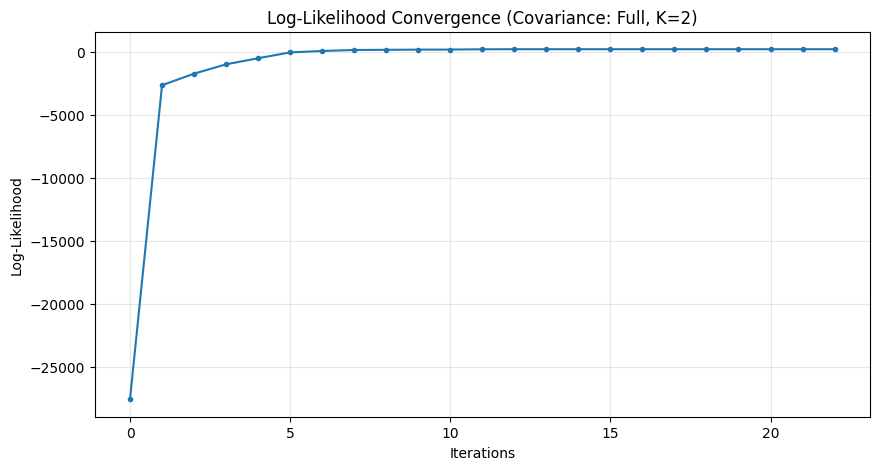

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data=results_df, x='n_components', y='BIC', hue='covariance_type', marker='o', ax=axes[0])
axes[0].set_title('BIC Score vs Number of Components')
axes[0].set_ylabel('BIC Score (Lower is Better)')
axes[0].grid(True, alpha=0.3)

sns.lineplot(data=results_df, x='n_components', y='AIC', hue='covariance_type', marker='o', ax=axes[1])
axes[1].set_title('AIC Score vs Number of Components')
axes[1].set_ylabel('AIC Score (Lower is Better)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

rep_key = ('full', 2)
if rep_key in trained_models:
    rep_model = trained_models[rep_key]
    
    plt.figure(figsize=(10, 5))
    plt.plot(rep_model.log_likelihood_history_, marker='.')
    plt.title(f'Log-Likelihood Convergence (Covariance: Full, K=2)')
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"Model {rep_key} not found in results.")